In [3]:
from lib import utils
from lib import models
from lib import executor
from lib.utils import nearest_integer_acc

import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

In [4]:
torch.cuda.set_device(2)

In [5]:
# load your data here. The following ensure this will work on Windows as well as Unix
# the data file has its Kodaira symbols already preprocessed 
path = '../data_files/sha/ecq_sha_B_100_conds_1_500000_reg.parquet'
df = utils.load_data(path)

# dropping columns that are not needed
df.drop(['conductor','adelic_level','lmfdb_label'], axis=1, inplace=True)

# get square root of order of sha
df['sqrt_sha'] = df['sha'].apply(lambda x: int(x**0.5))
df.drop('sha', axis=1, inplace=True)
print(f'Values counts of the square root of order of sha: ')
print(df.sqrt_sha.value_counts())

Loaded the dataset with 120 features and 3064705 curves..


Values counts of the square root of order of sha: 
sqrt_sha
1     2821178
2      158758
3       50428
4       18170
5        8501
6        2402
7        2153
8        1301
9         595
10        315
11        300
13        160
12        145
14         58
16         45
15         43
17         34
19         29
20         15
23         13
25         12
18          7
28          7
21          5
32          4
24          4
27          4
26          3
31          3
29          3
22          2
41          1
75          1
47          1
50          1
33          1
43          1
37          1
34          1
Name: count, dtype: int64


In [6]:
# to get a balanced dataset with equal amount of 1 and 4 labels
len_9 = df[df['sqrt_sha'] == 3].shape[0]
df_balanced = df[df['sqrt_sha'] == 2].sample(len_9) 
df_balanced = pd.concat([df_balanced, df[df['sqrt_sha'] == 3]])
print(f'Values counts of the square root of order of sha: ')
df_balanced.sqrt_sha.value_counts()

Values counts of the square root of order of sha: 


sqrt_sha
2    50428
3    50428
Name: count, dtype: int64

In [7]:
# Select your features

# BSD Features
df_BSD = df_balanced[['special_value', 'torsion', 'regulator', 'real_period', 'tamagawa_product','sqrt_sha']].copy()

# fix the seed for reproducibility
seed = 42

# first run an experiment using all variables from BSD formula

In [8]:
# choose model parameters
hidden_units = [128,64,32]

# check if we have cuda available
device = 'cuda'

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_BSD, 'sqrt_sha', if_regression=False)

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=False, dropout_rate=0.3, if_batchnorm=True).to(device)
# model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 5 and the output dimension is 2.
The model has 11,618 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [9]:
# choose training parameters
loss_func = nn.CrossEntropyLoss()
num_epochs = 30
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = accuracy_score

In [10]:
# Map labels to range starting from 0
df_BSD['sqrt_sha'] = df_BSD['sqrt_sha'].map({2: 0, 3: 1})

In [0]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_BSD, 'sqrt_sha', device, if_regression=False, random_state=seed)
# train the model
model, train_eval_hist, val_eval_hist, train_loss_hist, val_loss_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=False, verbose=False)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist, title='All BSD Features - Train and Validation Accuracy')

In [0]:
utils.plot_train_loss_hist(train_loss_hist, val_loss_hist, title='All BSD Features - Train and Validation Loss')

In [0]:
acc = executor.test(model, test_dataset, evaluator, if_regression = False)
print(f"Test accuracy: {acc:0.4f}")

# now delete one feature per time to test feature importance

In [11]:
# write a list of lists where each list is taking one feature out
# this is for the purpose of feature importance
features = ['special_value', 'torsion', 'regulator', 'real_period', 'tamagawa_product']
features_list = []
missing_feature = []
for i in range(len(features)):
    missing_feature.append(features[i])
    features_list.append([x for x in features if x != features[i]]+['sqrt_sha'])

Running model without special_value..
The input dimension is 4 and the output dimension is 2.


Save the model from epoch 24 with Training CrossEntropyLoss : 0.5496, Validation CrossEntropyLoss : 0.5557. Training accuracy_score : 0.6992, Validation accuracy_score : 0.6971, to ../trained_models/model.pth.


Test accuracy: 0.6846
----------------------------------
Running model without torsion..
The input dimension is 4 and the output dimension is 2.


/tmp/ipykernel_1868839/1531375221.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{'Feature Deleted': missing_feature[i], 'Accuracy': acc}])], ignore_index=True)


Save the model from epoch 27 with Training CrossEntropyLoss : 0.1439, Validation CrossEntropyLoss : 0.1445. Training accuracy_score : 0.9271, Validation accuracy_score : 0.9267, to ../trained_models/model.pth.


Test accuracy: 0.9294
----------------------------------
Running model without regulator..
The input dimension is 4 and the output dimension is 2.


Save the model from epoch 25 with Training CrossEntropyLoss : 0.0843, Validation CrossEntropyLoss : 0.0882. Training accuracy_score : 0.9324, Validation accuracy_score : 0.9294, to ../trained_models/model.pth.


Test accuracy: 0.9339
----------------------------------
Running model without real_period..
The input dimension is 4 and the output dimension is 2.


Save the model from epoch 29 with Training CrossEntropyLoss : 0.6350, Validation CrossEntropyLoss : 0.6343. Training accuracy_score : 0.6313, Validation accuracy_score : 0.6319, to ../trained_models/model.pth.


Test accuracy: 0.6312
----------------------------------
Running model without tamagawa_product..
The input dimension is 4 and the output dimension is 2.


Save the model from epoch 23 with Training CrossEntropyLoss : 0.3327, Validation CrossEntropyLoss : 0.3370. Training accuracy_score : 0.8341, Validation accuracy_score : 0.8318, to ../trained_models/model.pth.


Test accuracy: 0.8339
----------------------------------


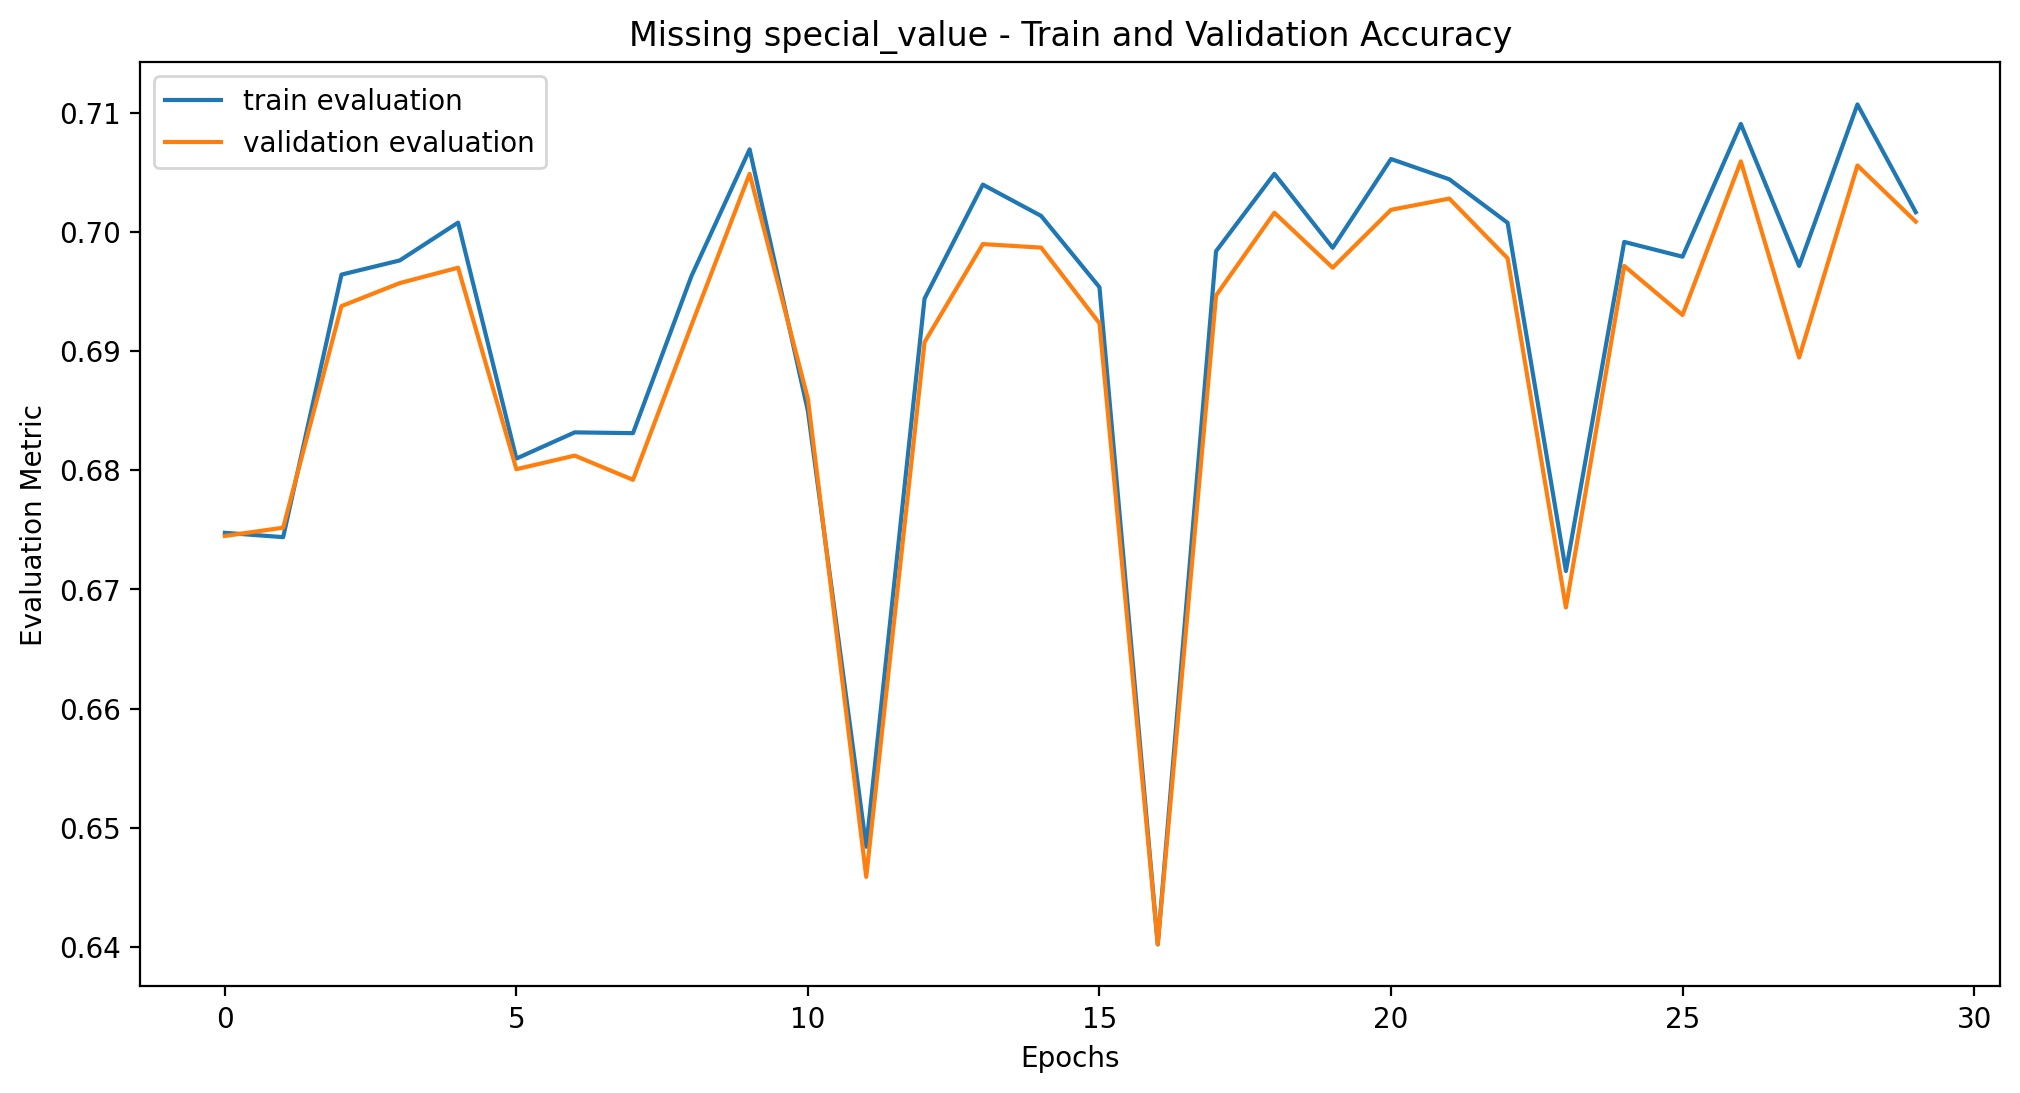

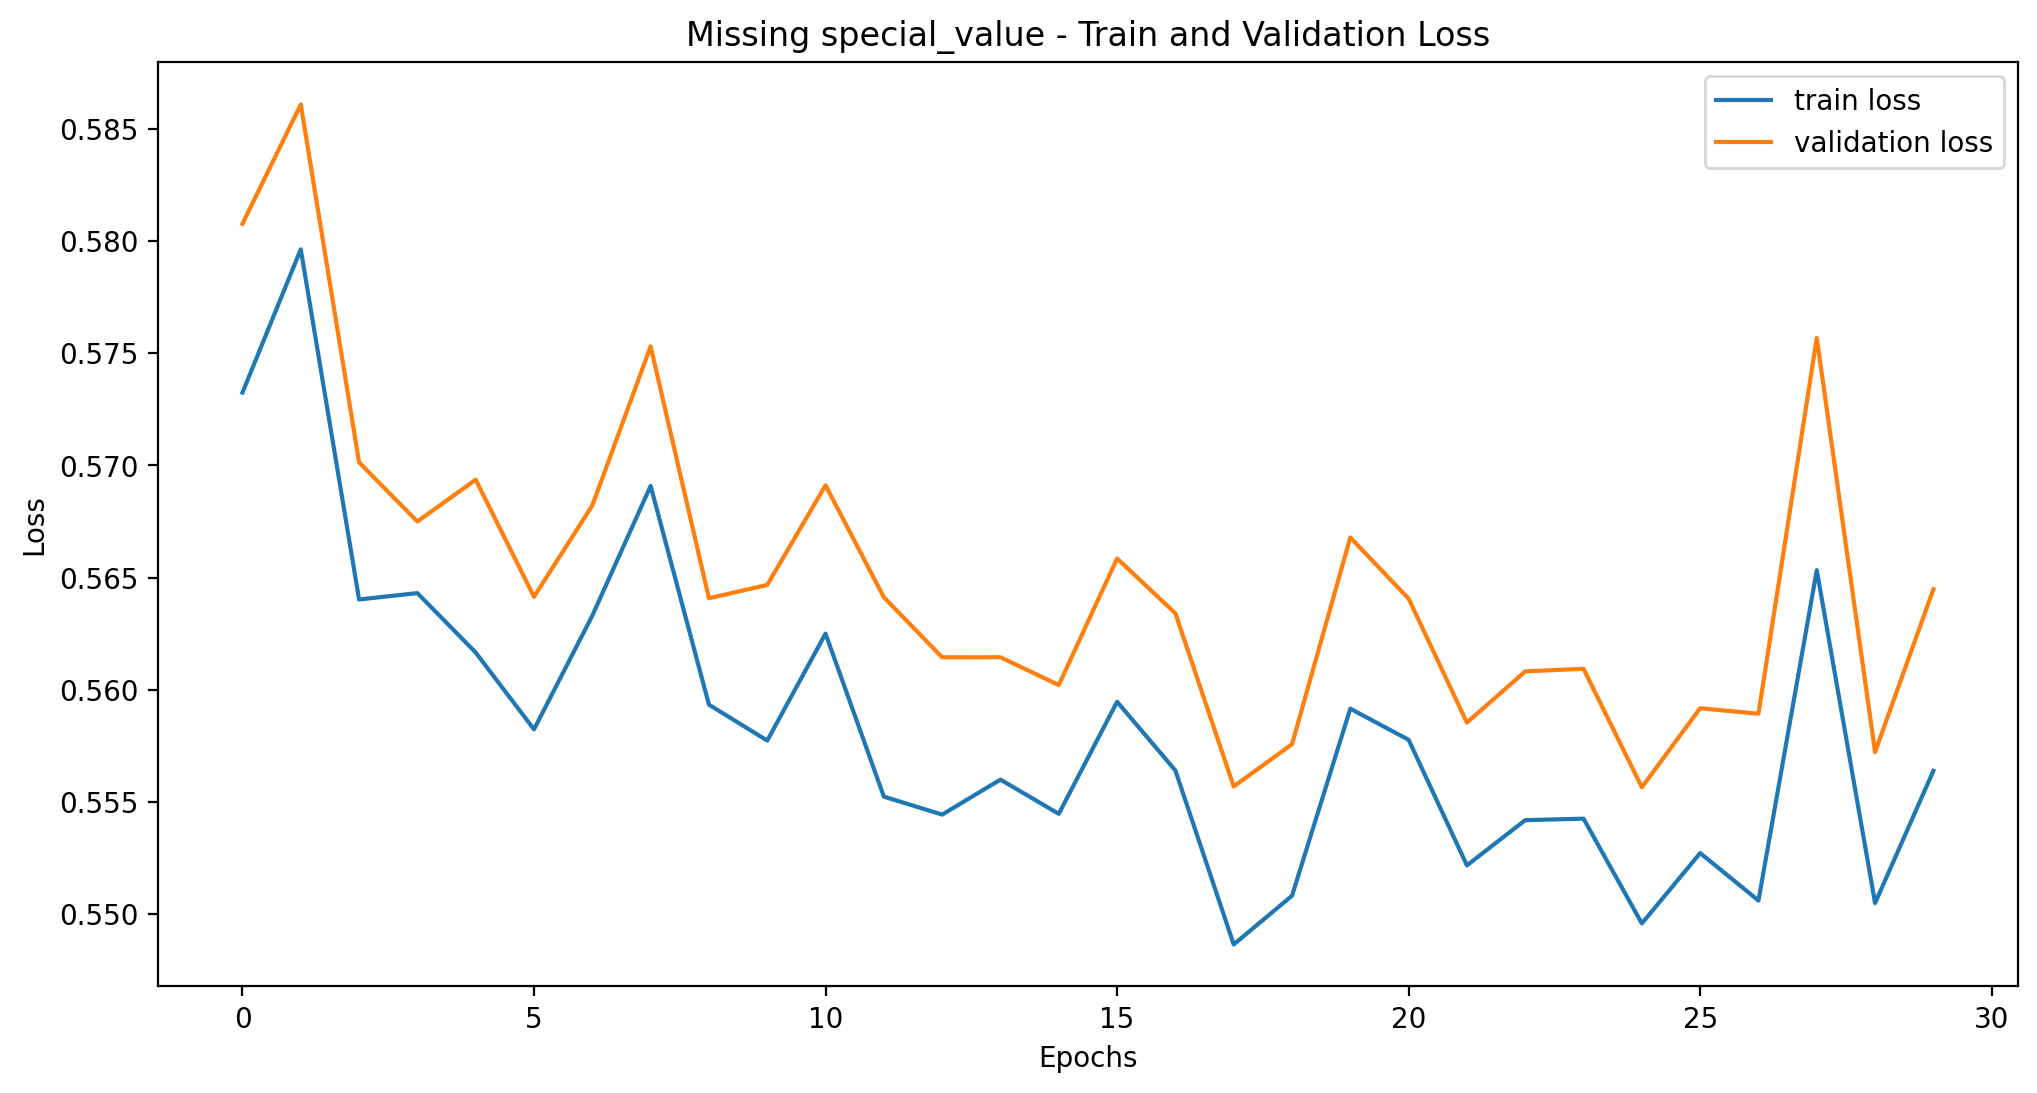

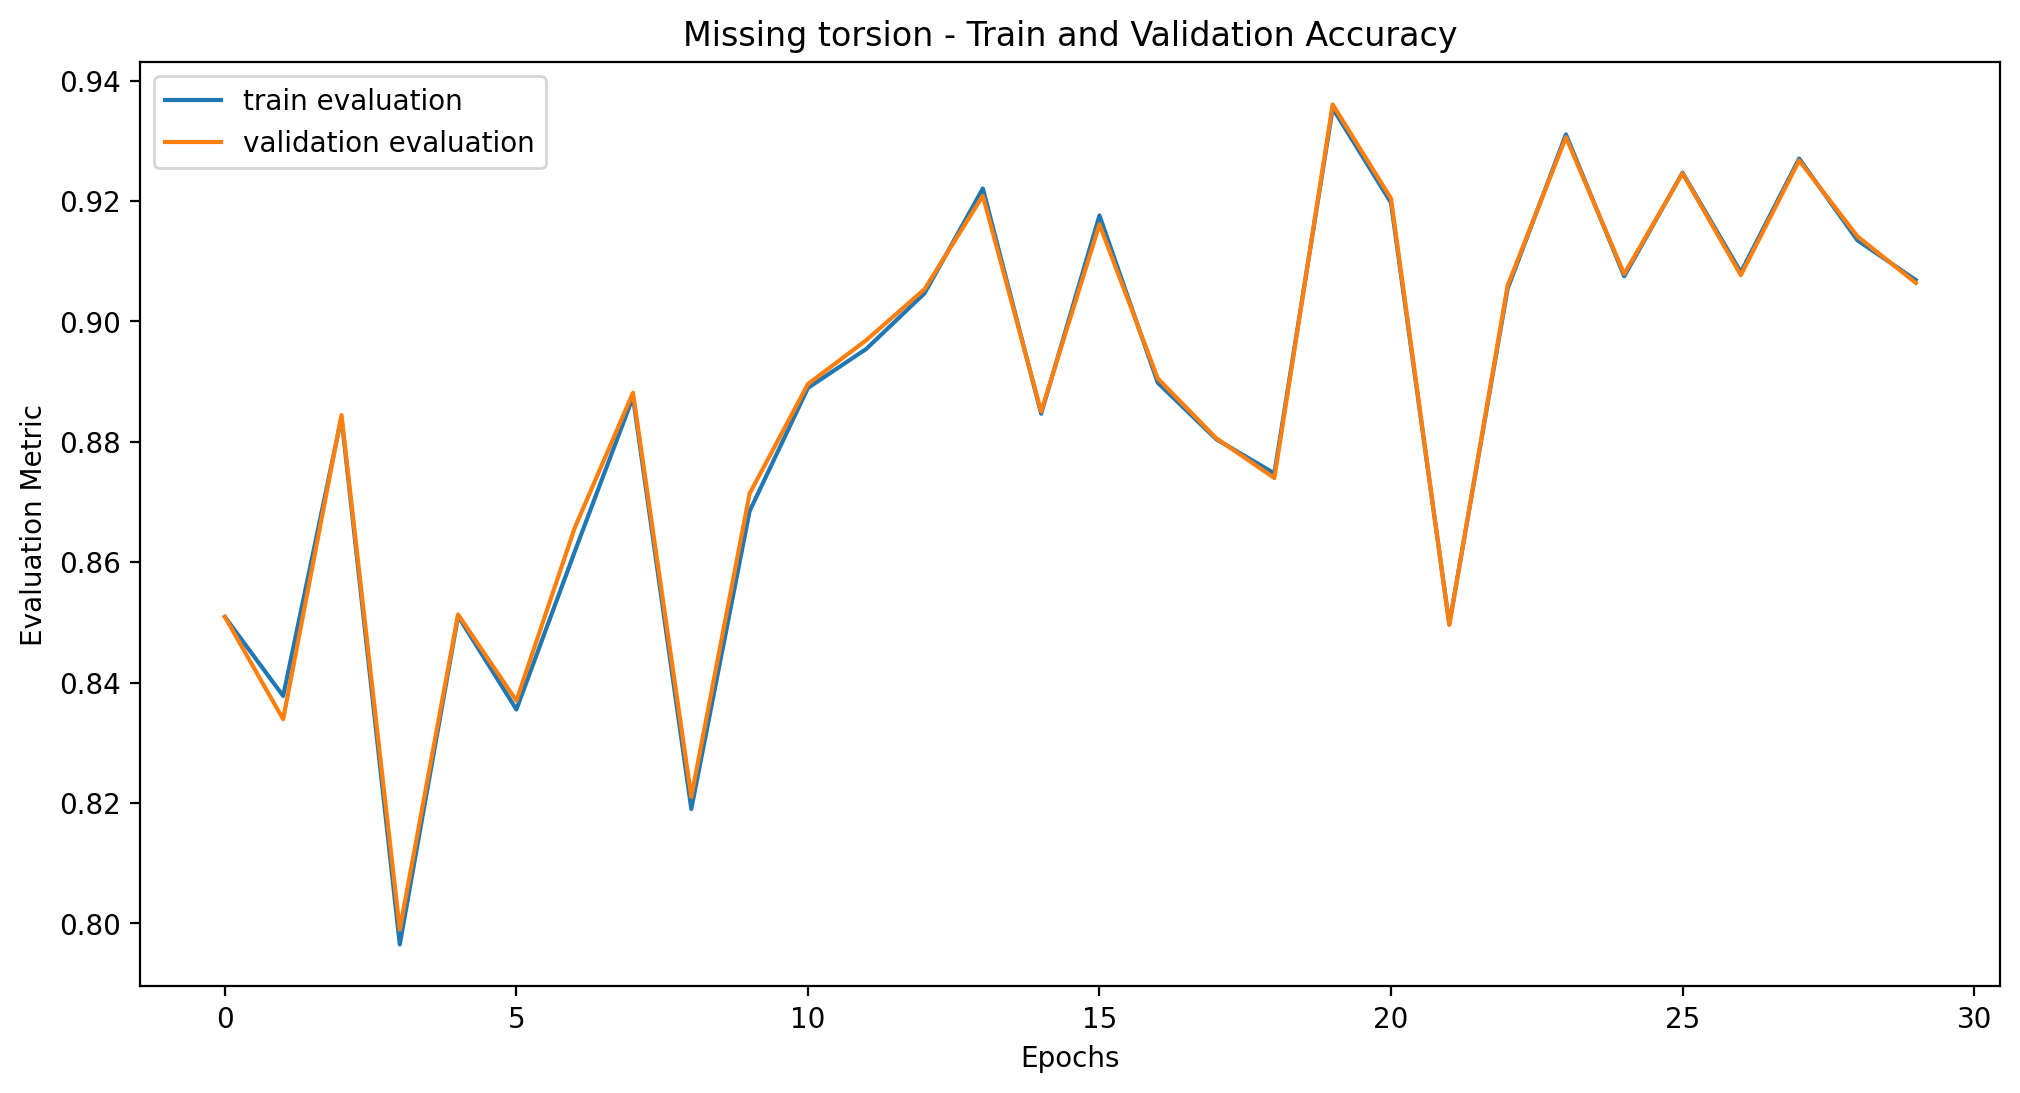

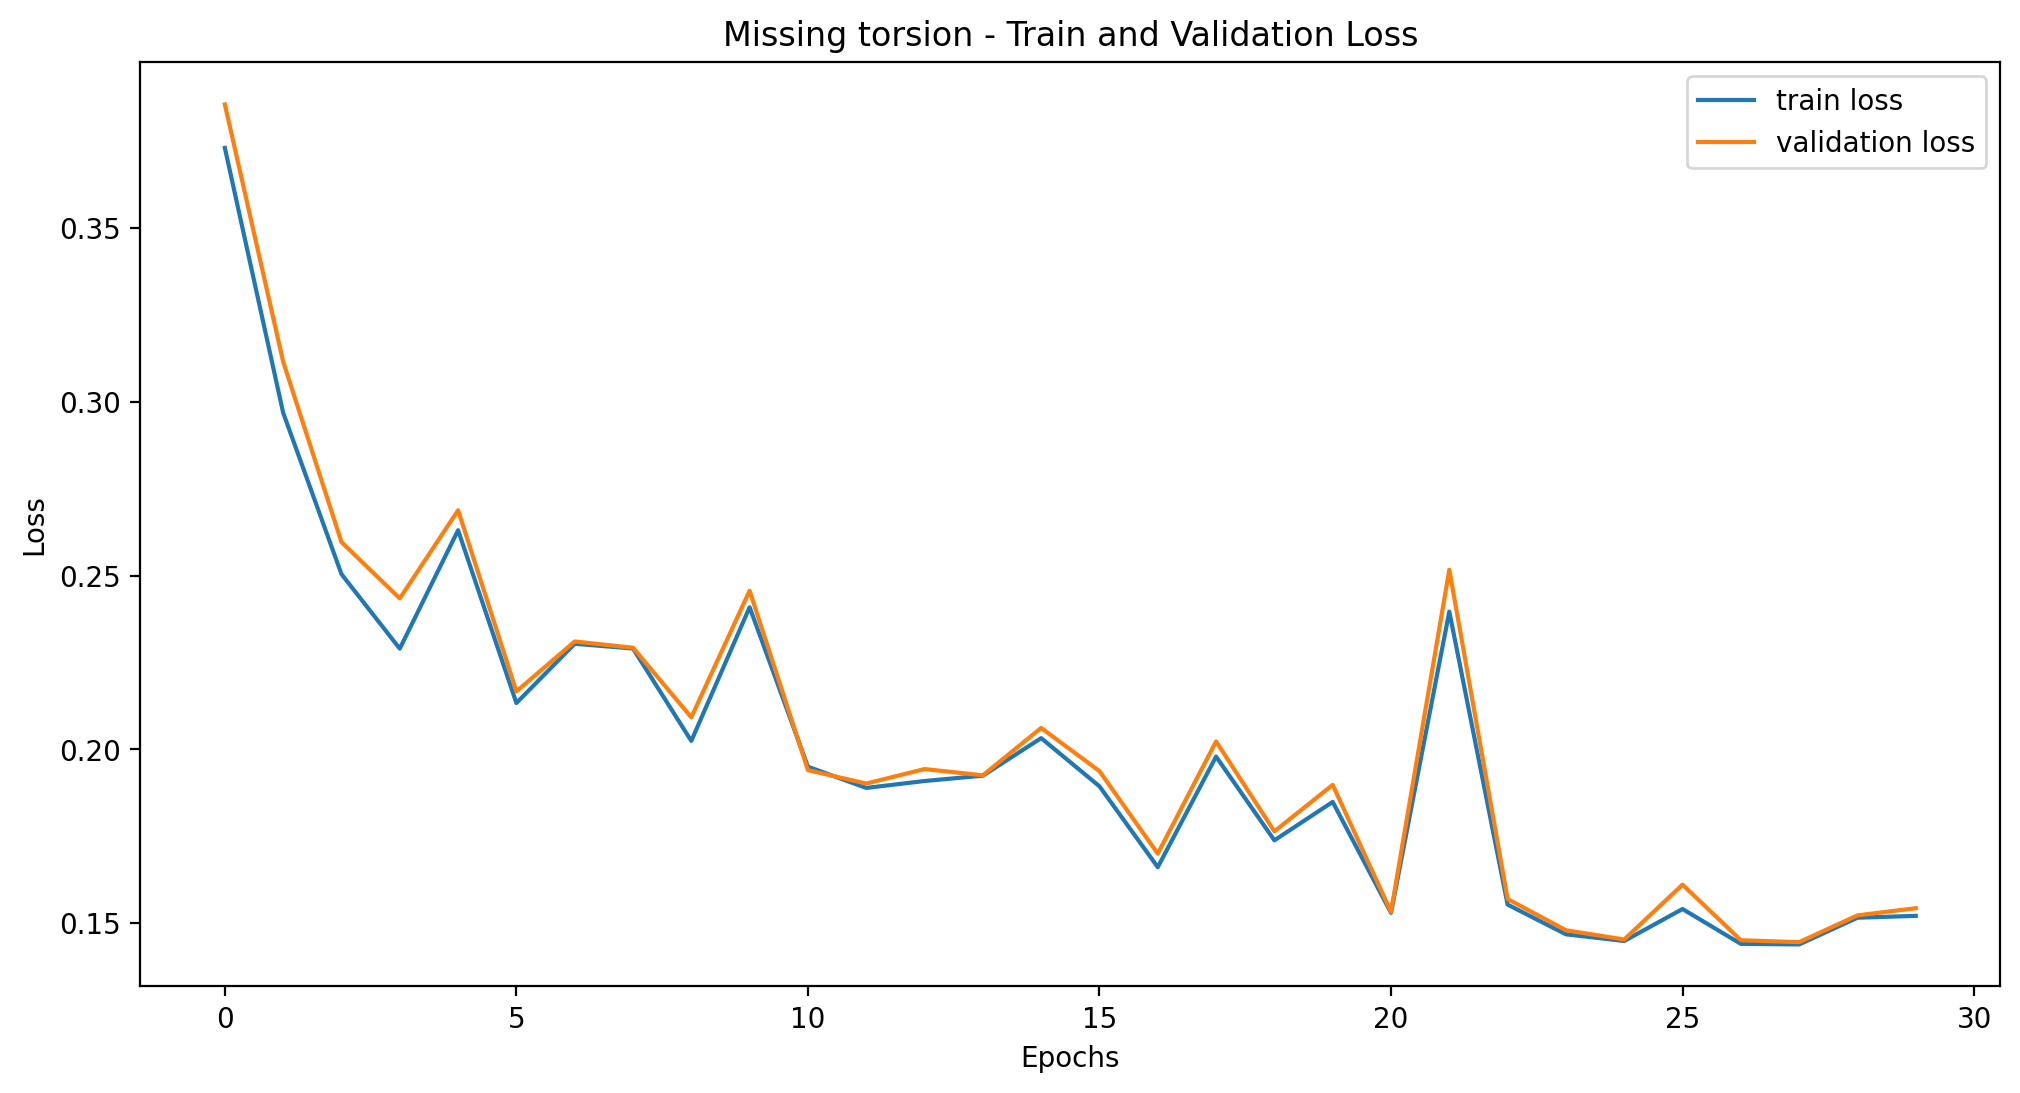

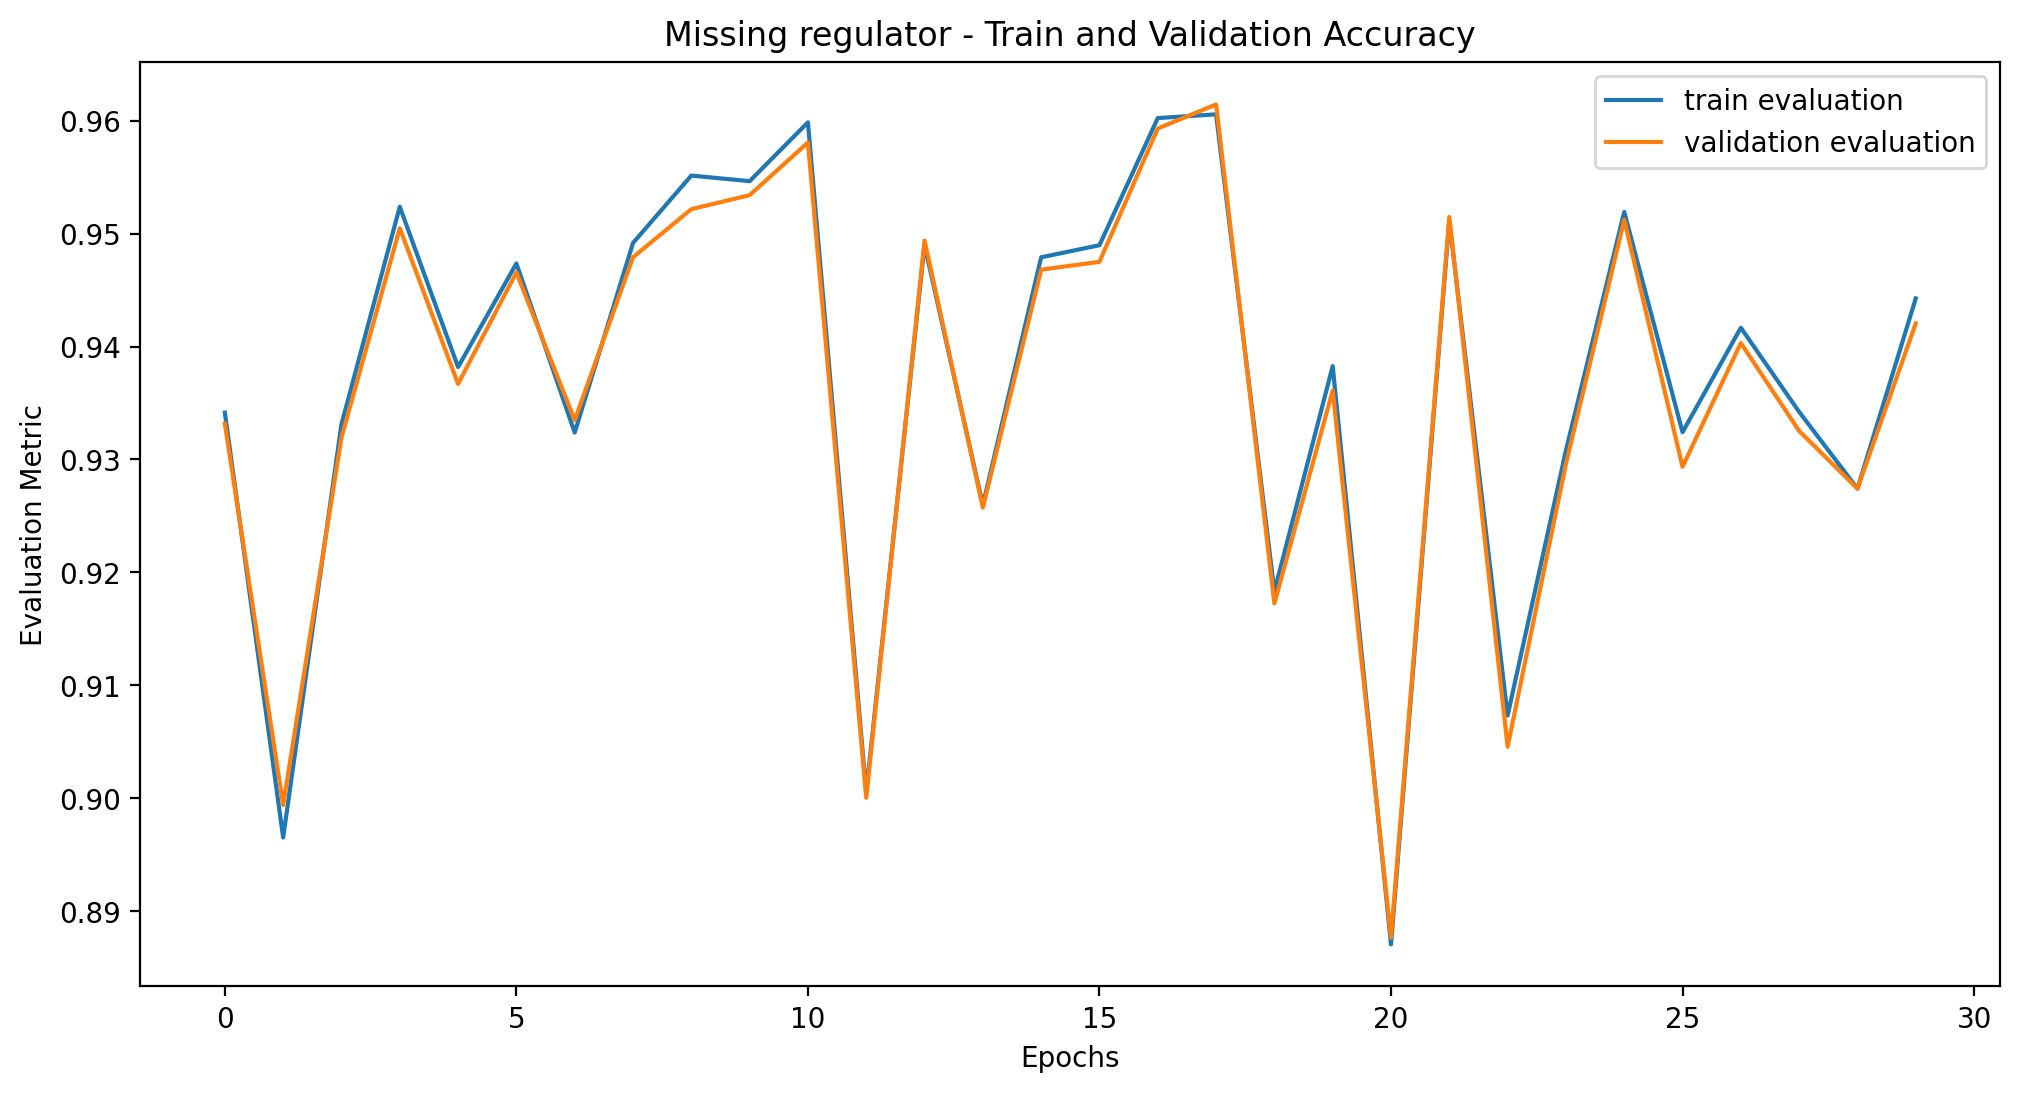

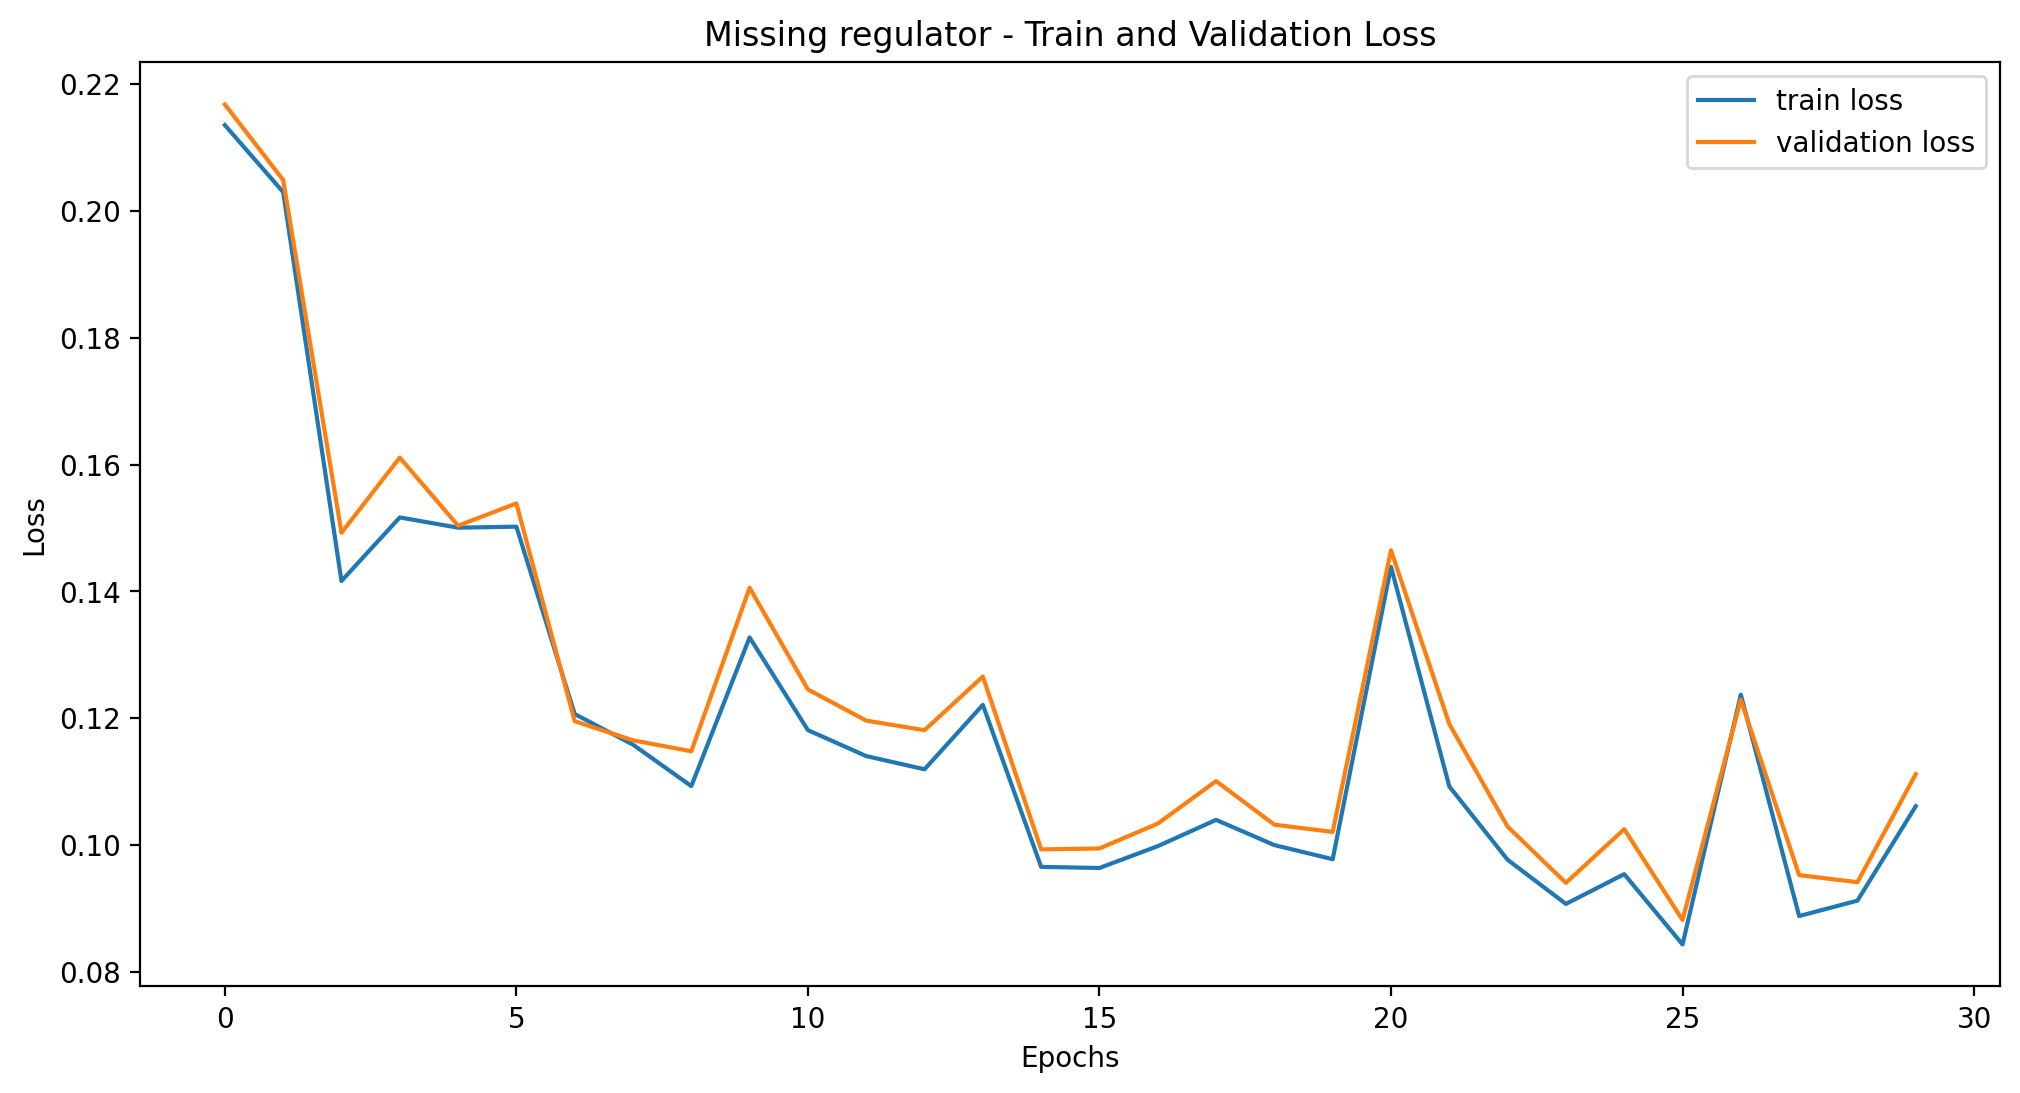

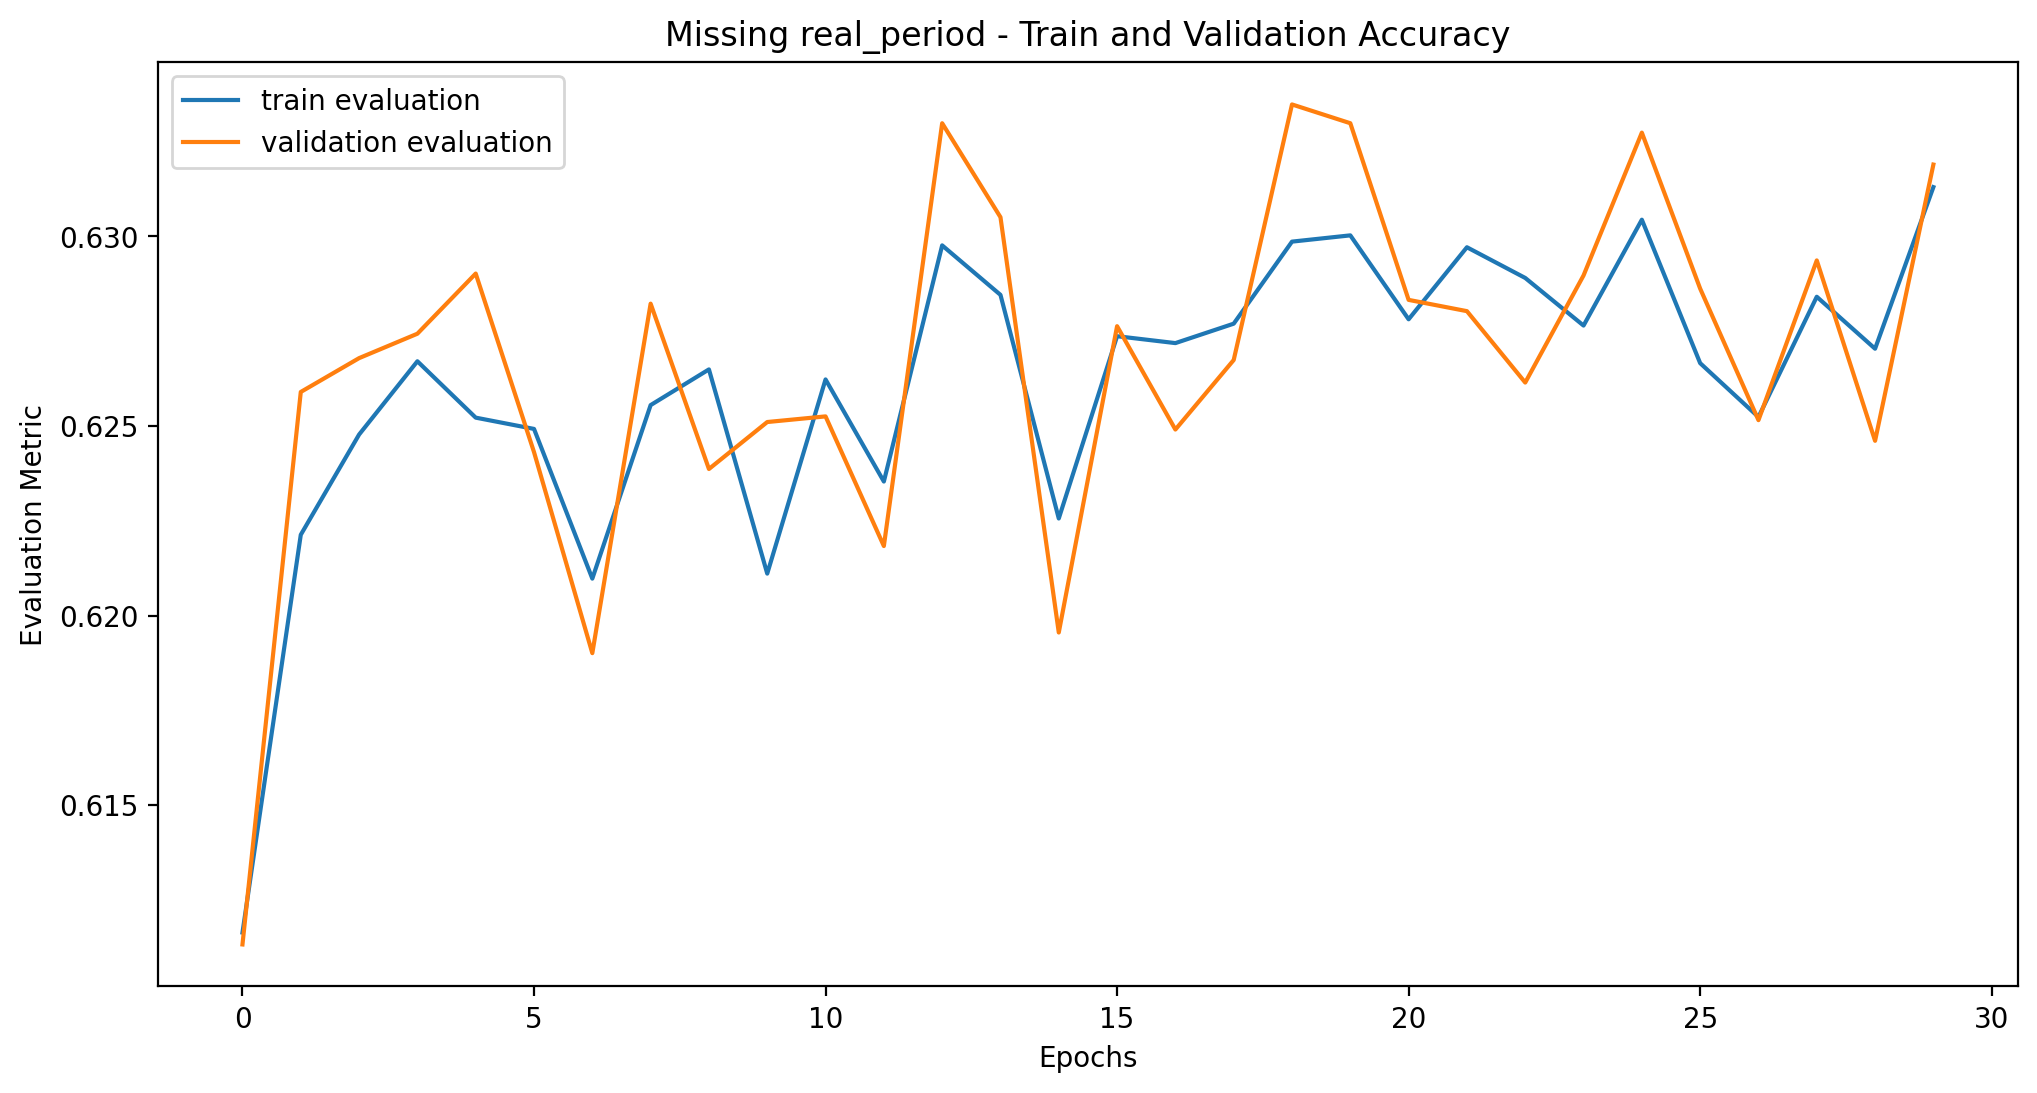

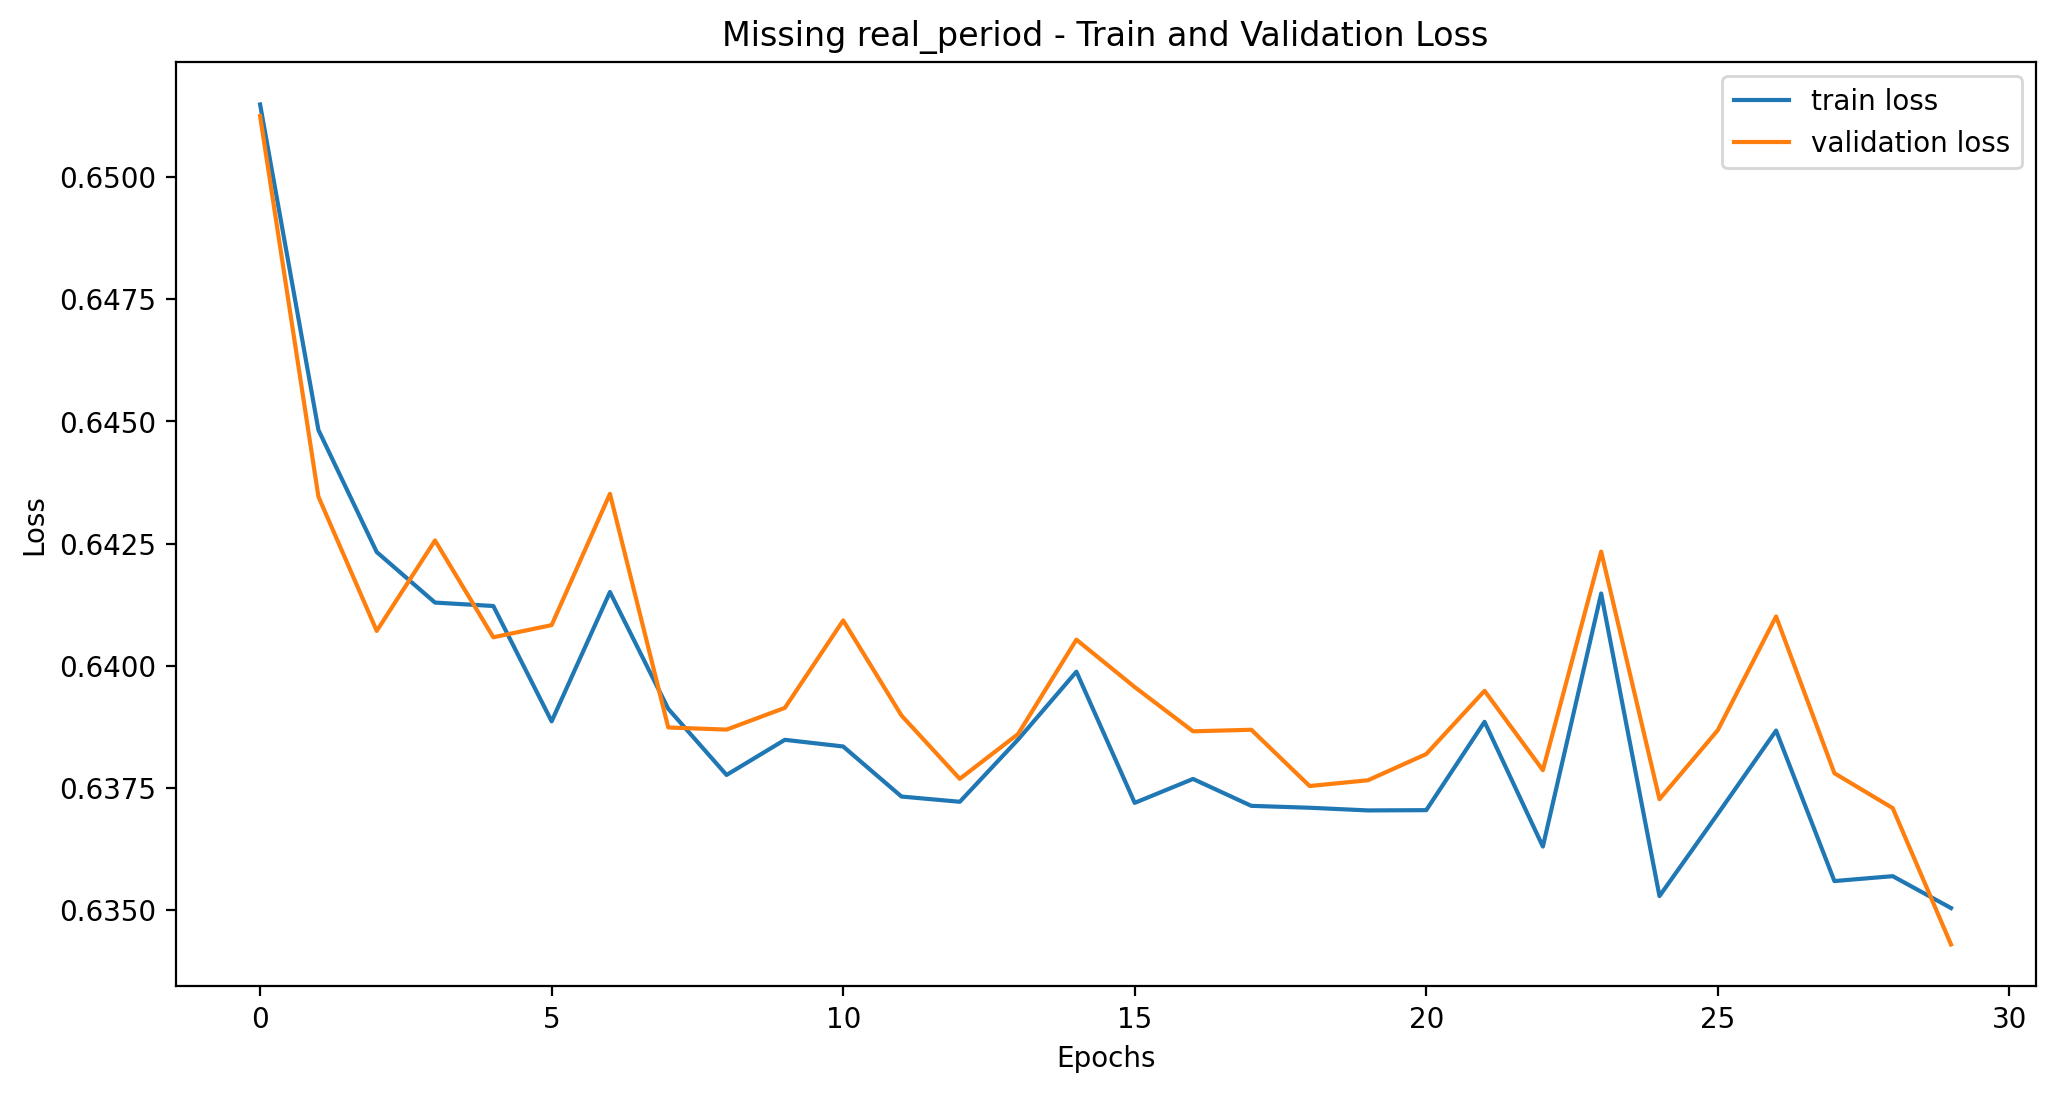

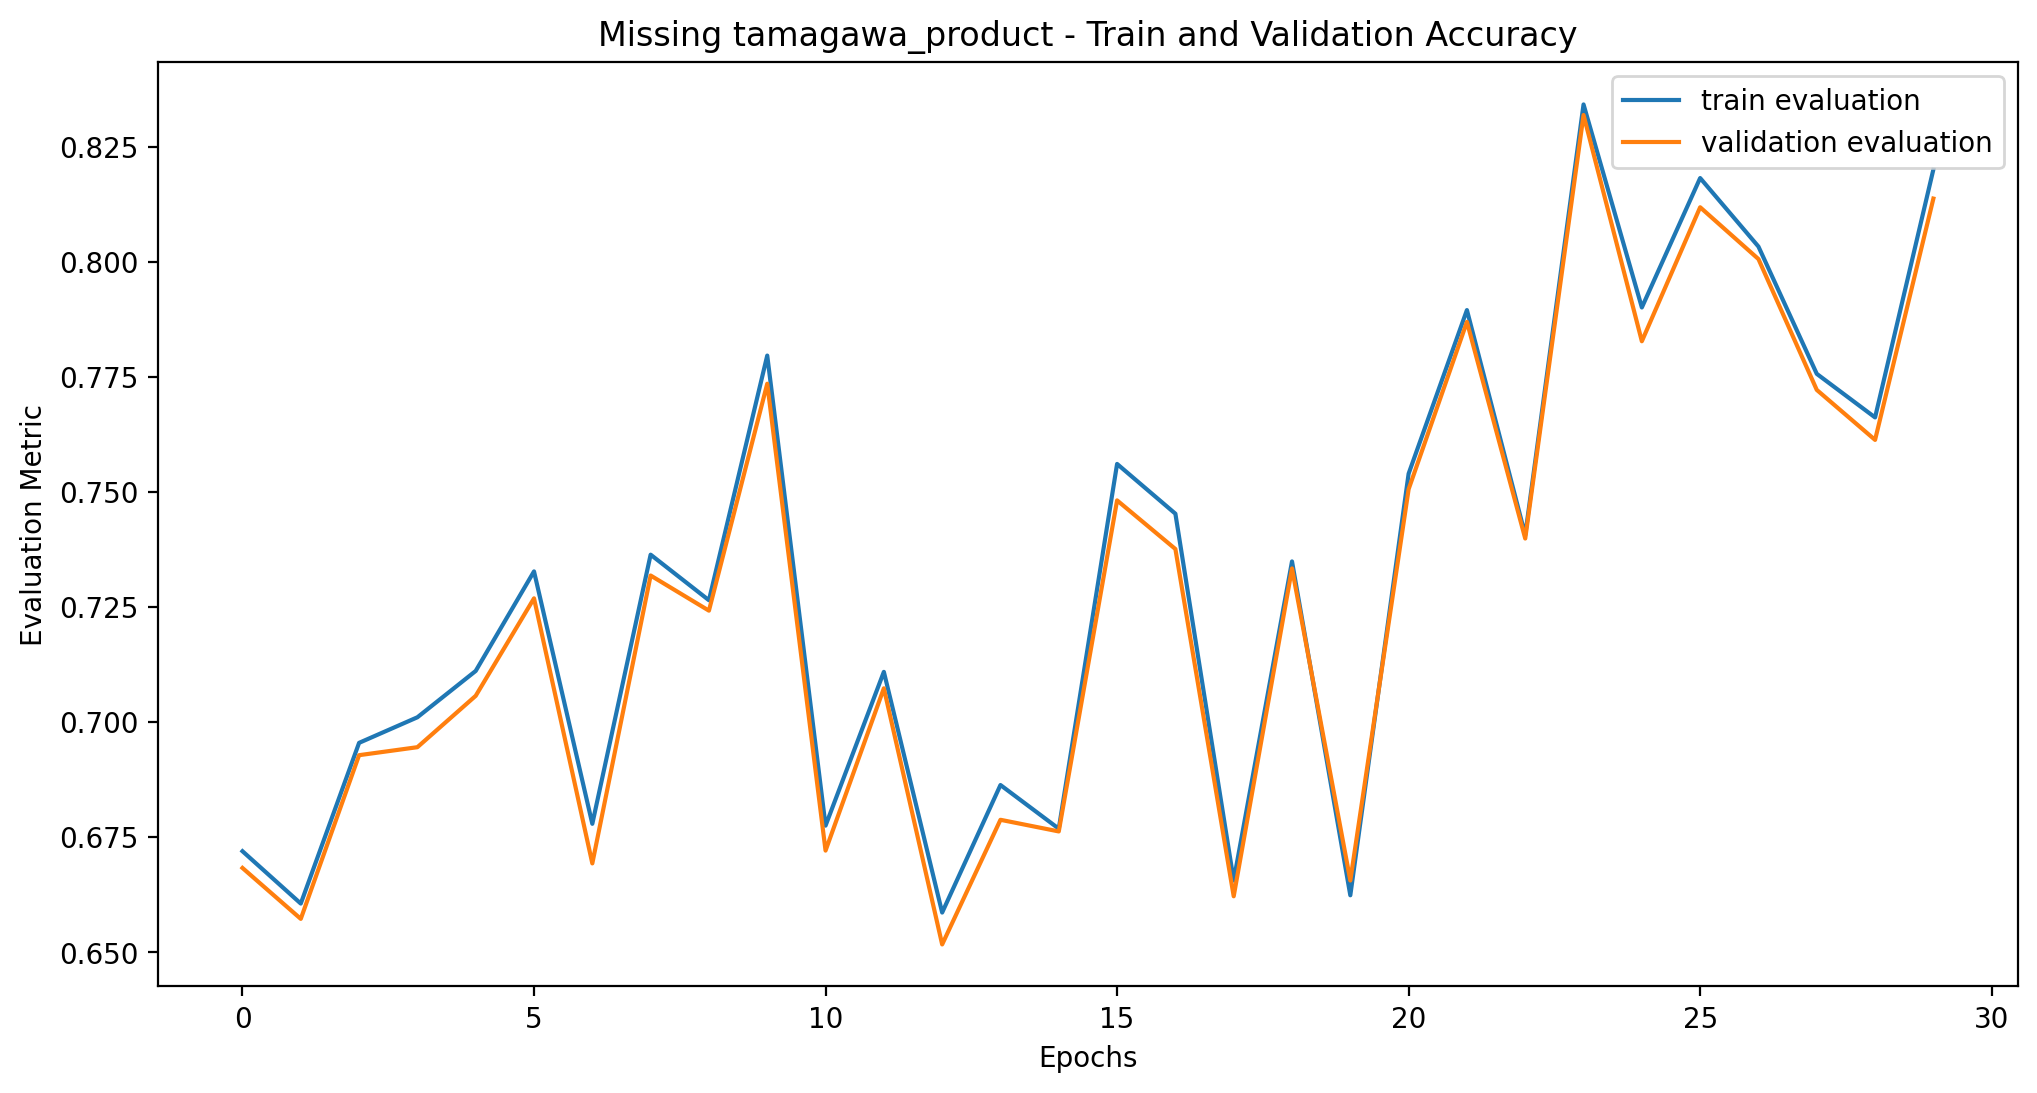

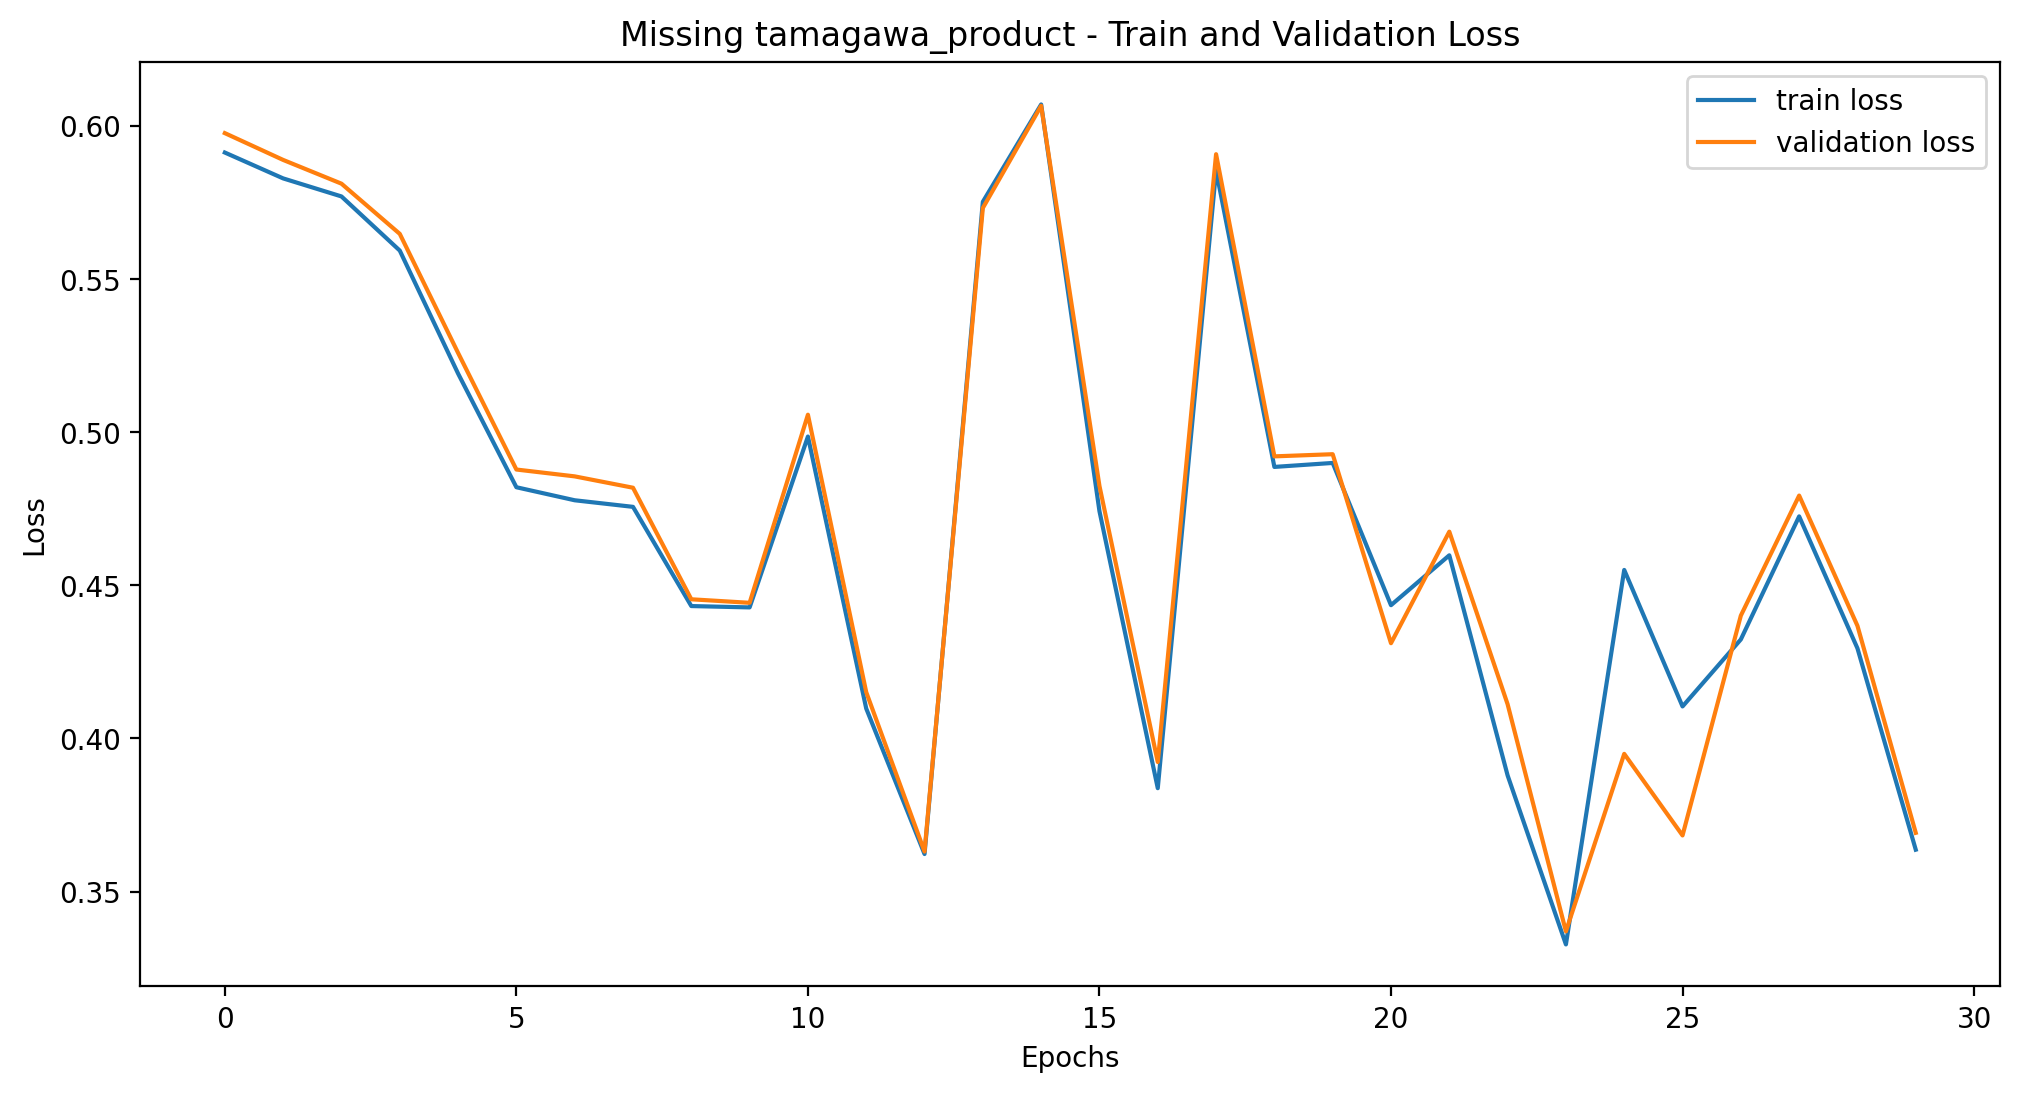

In [12]:
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Feature Deleted', 'Accuracy'])

for i in range(len(features_list)):
    print(f'Running model without {missing_feature[i]}..')
    df_sub = df_BSD.drop(columns=[missing_feature[i]])
    input_dim, output_dim = utils.get_input_output_dim(df_sub, 'sqrt_sha', if_regression=False)
    model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=False, dropout_rate=0.3, if_batchnorm=True).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr) # reinitialize optimizer
    train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_sub, 'sqrt_sha', device, if_regression=False, random_state=seed)
    model, train_eval_hist, val_eval_hist, train_loss_hist, val_loss_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=False, verbose=False)
    # plot train_eval_hist, val_eval_hist
    utils.plot_train_eval_hist(train_eval_hist, val_eval_hist, title=f'Missing {missing_feature[i]} - Train and Validation Accuracy', show = False)
    utils.plot_train_loss_hist(train_loss_hist, val_loss_hist, title=f'Missing {missing_feature[i]} - Train and Validation Loss', show = False)
    acc = executor.test(model, test_dataset, evaluator, if_regression=False)
    print(f"Test accuracy: {acc:0.4f}")
    print('----------------------------------')
    
   # Append the results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([{'Feature Deleted': missing_feature[i], 'Accuracy': acc}])], ignore_index=True)

In [13]:
print(results_df)

    Feature Deleted  Accuracy
0     special_value  0.684563
1           torsion  0.929358
2         regulator  0.933869
3       real_period  0.631221
4  tamagawa_product  0.833879
